In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib as mpl
import jupyterthemes as jt

""" Avoid error with Blas:GEMM not initializing when using GPU:
See: https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
"""
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
jt.jtplot.style()

K = keras.backend
np.random.seed(4)

# Chapter 17 
# Representation Learning with Autoencoders and Generative Adversarial Networks (GANs)

Autoencoders are neural networks that learn to copy their inputs. While this may sound trivial, the inputs are generally put under various constraints to make the task difficult, such as adding noise to the inputs or limiting size of the *latent representations*. 

What are *latent representations*? They are precisely what the autoencoder aims to learn. They are dense representations of the input, learned without supervision. They typically have lower dimensionality than the inputs, so this also makes autoencoders useful for dimensionality reduction.

Geberative adversarial networks are composed of two neural nets: a *generator* that is trying to generate some data that looks like the training data (e.g. human faces) and a *discriminator*, which tries to tell which of the images are real data and which were artificially generated by the generator. During trainig, these two models are competing agains each other. GANs are considered on of the most important ideas in ML in recent years.

We'll start by looking at autoencoders

# Efficient Data Representations

Autoencoders are composed of two parts:
- *Encoder (recognition network)* whose job is to convert the inputs to a latent representation
- *Decoder (generative network)* whose job is to convert the internal representation to the outputs

Their architecture are similar to that of MLPs, except that the number of outputs is equal to the number of inputs. Outputs are called *reconstructions* since the autoencoder tries to recostruct the inputs from the latent representation. The cost function will contain a *reconstruction loss* that penalizes the model for generating poor reconstructions (i.e. outputs that do not look like the inputs).

The example in the book (page 570) shows a simple autoencoder with 3 inputs, an encoder with 2 neurons and a decoder with 3 output neurons. The internal representation of the encoder has 2 dimensions instead of 3, and we say the autoencoder is *undercomplete*. Such an autoencoder can't trivially copy the inputs to its codings (internal represenation), but its goal is to output a copy of the inputs. Because of the constraints, the autoencoder is forced to learn the most important features of the inputs data.

## PCA with an Undercomplete Linear Autoencoder

Let's dive in by creating an undercomplete autoencoder. The designed model will only use linear activations and have MSE as its cost function. The result will be an autoencoder that performs PCA

In [1]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="SGD")

Generate some random 3D data

In [2]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

And fit. Note the X_train is used as both the input and the output as we're trying to re-construct the inputs.

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = autoencoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 1s 4ms/step - loss: 0.5540
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.5541
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5474
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4962
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5019
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4718
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4752
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4479
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4645
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4101
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4138
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4023
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

If we plot the first two dimensions of the codings, we will se a 2D projection of the data as a result, just like PCA

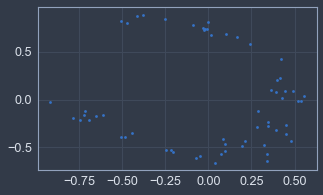

In [7]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(codings[:, 0], codings[:, 1], '.')
plt.show()

## Stacked Autoencoders

Just like other Neural Nets, we can add more hidden layers to our autoencoder. Such autoencoders are called *stacked autoencoders* and their architecture resembles a sandwich, in that the layers in the encoder (except the last one) are repeated in the decoder but in reverse order. (picture page 572)

Let's use fashion MNIST to build a stacked autoencoder

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounding_accuracy(y_true, y_pred):
    """Rounds both target and output to 0,1 and calculates the accuracy"""
    round_true = tf.math.round(y_true)
    round_preds = tf.math.round(y_pred)
    return tf.metrics.binary_accuracy(round_true, round_preds)

In [11]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"), # central layer
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounding_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3797 - rounding_accuracy: 0.8508 - val_loss: 0.3103 - val_rounding_accuracy: 0.9121
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3063 - rounding_accuracy: 0.9148 - val_loss: 0.3031 - val_rounding_accuracy: 0.9179
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2994 - rounding_accuracy: 0.9211 - val_loss: 0.2975 - val_rounding_accuracy: 0.9244
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2942 - rounding_accuracy: 0.9253 - val_loss: 0.2943 - val_rounding_accuracy: 0.9283
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2914 - rounding_accuracy: 0.9276 - val_loss: 0.2915 - val_rounding_accuracy: 0.9284
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2900 - rounding_accuracy: 0.9290 - val_loss: 0.2899 - val_rounding_accuracy: 0.9304
Epoch 7/10
1719/1719 [======

Note:
- The decoder uses sigmoid activation for its outputs as we're outputing 0 or 1 for each pixel. So we're treating this as a classification problem and use binary_crossentropy as the loss function. Framing the problem this way, rather than as a regression problem, speeds up convergence
- Since we are treating the outputs as probabilities that the pixel should be black, we define a custom accuracy function that rounds the targets and outputs to 0/1 

### Visualizing the reconstructions

Lets' plot the reconstructions and see how the model did

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

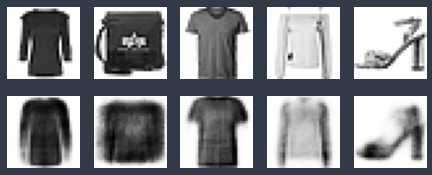

In [12]:
show_reconstructions(stacked_ae)

Reconstructions are recognizable but a bit lossy. To improve them, we can deepen the architecture, train for longer or make the codings larger. But if we make the network too powerful, it will manage to reconstruct the images perfectly without learning any useful patterns.

### Visualizing the Fashio MNIST dataset

We can now use the autoencoder to reduce dimensionality of fashion MNIST. If we do that, we'll see that it doesn't perform as other algorithms (chapter 8). The advantage they have, is that they can handle large amounts of data with many instances and features, so one viable strategy is to use the autoencoder to reduce dimensionality to a reasonable level, then use another algorithm.

Let's do this with T-SNE

In [10]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid) # Encoder reduces dimension to 30
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

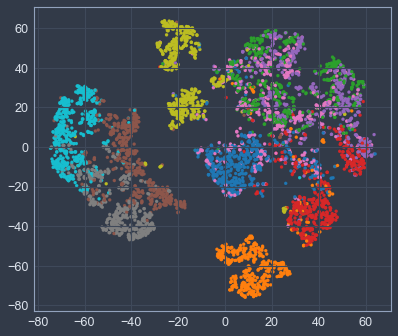

In [11]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

### Unsupervised pre-training using stacked autoencoders

In chapter 11 we pointed out that if we have a complex supervised task, but do not have a lot of labeled training data, we can find a neural net that was pretrained in a similar task and re-use its lower layers. This makes it possible to create a high performing model without vasts amount of labelled data as the NN won't have to learn all the low level features

In a similar fashion, if we have a large dataset that is mostly unlabelled, we can first train a stacked autoencoder using all the data, then re-use the lower layers to create a NN for our actual task and train it using the labelled data. See fig 17-6 on page 576

One thing to note: If we don't have much labelled training data, we may want to freeze the pre-trained layers (at least the lower ones).

We'll explore implementing this architecture in the exercises for the chapter. 

### Tying Weights

When the Autoencoder is symmetrical, we can halve the number of weights to fasten training and reduce the risk of overfitting. To do this, we *tie* the weights if the decoder layers to the weights of the encoder layer.

More specifically, if our autoencoder has *N* layers (not counting input) and $\textbf{W}_L$ represents the weights of the *L*<sup>th</sup> layer, then the decoder layer weights can be defined as:
$$ \textbf{W}_{N-L+1} = \textbf{W}_{L}^{\intercal} $$
with $L = 1, 2, ..., N/2$.

We implement this with a custom class

In [12]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    
    def call(self, inputs):
        z = tf.matmul(inputs, 
                      self.dense.weights[0], # weights from another layer
                      transpose_b=True) # Transposes the second argument
        return self.activation(z + self.biases)

Let's build a new stacked_encoder

In [13]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounding_accuracy])
tied_ae.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28)            82414     
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [14]:
stacked_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3720 - rounding_accuracy: 0.8574 - val_loss: 0.3091 - val_rounding_accuracy: 0.9161
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2994 - rounding_accuracy: 0.9203 - val_loss: 0.2943 - val_rounding_accuracy: 0.9281
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2929 - rounding_accuracy: 0.9270 - val_loss: 0.2918 - val_rounding_accuracy: 0.9315
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2892 - rounding_accuracy: 0.9300 - val_loss: 0.2894 - val_rounding_accuracy: 0.9298
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2868 - rounding_accuracy: 0.9326 - val_loss: 0.2867 - val_rounding_accuracy: 0.9352
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2854 - rounding_accuracy: 0.9340 - val_loss: 0.2853 - val_rounding_accuracy: 0.9353
Epoch 7/10
1719/1719 [======

Slightly better performance with half the number of parameters!

### Training one Autoencoder at a time

So far we have trained the autoencoder in one go, however it is also possible to dissect the model into smaller autoencoder and train each individually. This isn't used as much nowadays, but it used to be the only way to train Neural networks back in 2006. The approach is called *Greedy layerwise training*.

See page 578 for a description and the [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for an implementation

## Convolutional Autoencoders

Even with this new architecture, when dealing with images Dense layers will only get you so far. Using a Convolutional Autoencoder will work much better.

The Encoder will be a regular CNN composed of convolutional and pooling layers. Its job is to reduce the spatial dimensionality of the inputs (height, width) while increasing depth (i.e. number of feature maps). 

The Decoder does the opposite, upscaling the image and reducing its depth back to the original dimensions. For this, we can use Transpose Convolutional layers.

Transpose convolutional (or deconvolutional) layers undo the effects of a normal convolution

In [16]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
                                 padding="valid", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2,
                                 padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounding_accuracy])

history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2814 - rounding_accuracy: 0.9372 - val_loss: 0.2820 - val_rounding_accuracy: 0.9391
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2810 - rounding_accuracy: 0.9375 - val_loss: 0.2844 - val_rounding_accuracy: 0.9364
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2806 - rounding_accuracy: 0.9380 - val_loss: 0.2828 - val_rounding_accuracy: 0.9366
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2804 - rounding_accuracy: 0.9382 - val_loss: 0.2811 - val_rounding_accuracy: 0.9392
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2801 - rounding_accuracy: 0.9383 - val_loss: 0.2863 - val_rounding_accuracy: 0.9359
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2799 - rounding_accuracy: 0.9385 - val_loss: 0.2809 - val_rounding_accuracy: 0.9396
Epoch 7/10
1719/1719 [======

### Recurrent Autoencoders

When dealing with time-series data, we can use recurrent layers in our autoencoders. The approach is similar, the encoder will be a sequence-to-vector RNN converting the sequence to a single vector. The decoder does the reverse.

We can define a recurrent AE conveniently so that it can process sequences of any length with 28 dimensions per time step, i.e. it can process Fashion MNIST images by treating each image as a sequence of rows: at each time step the RNN processes a single row of 28 pixels.

In [21]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
                     metrics=[rounding_accuracy])

with tf.device('/CPU:0'):
    recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_train, X_train))

Epoch 1/10
1719/1719 [==============================] - 71s 39ms/step - loss: 0.4260 - rounding_accuracy: 0.8177 - val_loss: 0.3321 - val_rounding_accuracy: 0.8907
Epoch 2/10
1719/1719 [==============================] - 66s 38ms/step - loss: 0.3246 - rounding_accuracy: 0.8970 - val_loss: 0.3261 - val_rounding_accuracy: 0.8982
Epoch 3/10
1719/1719 [==============================] - 66s 39ms/step - loss: 0.3122 - rounding_accuracy: 0.9069 - val_loss: 0.3089 - val_rounding_accuracy: 0.9109
Epoch 4/10
1719/1719 [==============================] - 67s 39ms/step - loss: 0.3047 - rounding_accuracy: 0.9131 - val_loss: 0.3161 - val_rounding_accuracy: 0.9055
Epoch 5/10
1719/1719 [==============================] - 67s 39ms/step - loss: 0.3009 - rounding_accuracy: 0.9167 - val_loss: 0.2981 - val_rounding_accuracy: 0.9198
Epoch 6/10
1719/1719 [==============================] - 66s 38ms/step - loss: 0.2977 - rounding_accuracy: 0.9198 - val_loss: 0.2933 - val_rounding_accuracy: 0.9233
Epoch 7/10
1719/

So far we looked at various types of autoencoders (basic, stacked, convolutional, recurrent) as well as some way to train them (single shot, layer by layer) for a couple of applications (data viz and unsupervised pretraining).

We'll now look at other constraints that we can appliy with autoencoders.

## Denoising Autoencoders

Aonther way we can force the autoencoder to learn useful features is to train is to add noise to its inputs and training it to recover the noise-free inputs. 

The noise can be pure Gaussian noise or it can be randomly switched-off inputs (just like dropout). Below an implementation with GaussianNoise

In [33]:
gn_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(stddev=0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
gn_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
gn_ae = keras.models.Sequential([gn_encoder, gn_decoder])
gn_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
               metrics=[rounding_accuracy])

gn_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3879 - rounding_accuracy: 0.8439 - val_loss: 0.3150 - val_rounding_accuracy: 0.9073
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3123 - rounding_accuracy: 0.9092 - val_loss: 0.3070 - val_rounding_accuracy: 0.9116
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3049 - rounding_accuracy: 0.9154 - val_loss: 0.3001 - val_rounding_accuracy: 0.9208
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3005 - rounding_accuracy: 0.9196 - val_loss: 0.2988 - val_rounding_accuracy: 0.9213
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2973 - rounding_accuracy: 0.9225 - val_loss: 0.2941 - val_rounding_accuracy: 0.9272
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2964 - rounding_accuracy: 0.9238 - val_loss: 0.2933 - val_rounding_accuracy: 0.9284
Epoch 7/10
1719/1719 [======

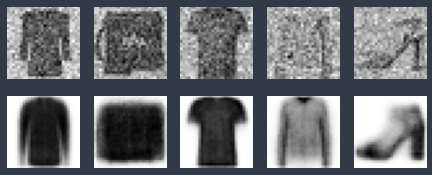

In [32]:
gaussian_noise = keras.layers.GaussianNoise(stddev=.2)
show_reconstructions(gn_ae, images=gaussian_noise(X_valid[:5], training=True))

The image above shows some noisy input against the re-constructed outputs. Autoencoders can be used for removing noise from images (wonder if it can be used for other sorts of data as well ?)

## Sparse Autoencoders

By now, you should understand that at the core of autoencoders is the latent representation generated by the encoder, so if we can make the autoencoder learn only the important features and use them in the latent representation we'll have a good model.

Another constraint we can add to ensure good representations is *sparsity*: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, only 5% of the neurons in the coding layer may be significantly active, which in turn forces the autoencoder to represent each input as a small number of activations and so each neuron in the coding layer will represent a useful feature. (e.g. if you could only speak a few words per month, you'd make sure they were worth listening to)

One way to achieve this is to use a sigmoid activation in the coding layer (constraining values to [0, 1]), a large coding layer and some $l_1$ regularization to the coding layer's output. The decoder will remain the same

In [38]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"), # coding layer
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
               metrics=[rounding_accuracy])

sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4744 - rounding_accuracy: 0.7857 - val_loss: 0.3730 - val_rounding_accuracy: 0.8645
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3639 - rounding_accuracy: 0.8739 - val_loss: 0.3509 - val_rounding_accuracy: 0.8806
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3453 - rounding_accuracy: 0.8867 - val_loss: 0.3445 - val_rounding_accuracy: 0.8817
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3372 - rounding_accuracy: 0.8923 - val_loss: 0.3329 - val_rounding_accuracy: 0.8952
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3288 - rounding_accuracy: 0.8995 - val_loss: 0.3262 - val_rounding_accuracy: 0.9026
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3245 - rounding_accuracy: 0.9025 - val_loss: 0.3252 - val_rounding_accuracy: 0.9061
Epoch 7/10
1719/1719 [======

The `ActivityRegularization` layer simply returns its inputs, but also adds a training loss equal to the sum of the absolute values of its inputs (only during training). This penalty encourages the network to produce codings close to 0 but, since it is also penalized if the final output does not reconstruct the inputs correctly, it will have to output at least a few non-zero values.

The $l_1$ norm instead of $l_2$ pushes the neural network to preserve the most important codings while eliminating unimportant ones (rather than just reducing all codings)

A better approach, which often leads to better results, is to measure the sparsity of the coding layer at each training iteration, penalizing the model if the measured sparsity differs from a target sparsity. To do so, we measure the average activation of each neuron in the coding layer over the whole training batch. Note that for this, the batch size must not be too small, else the mean will be inaccurate.

Once we have the mean activation per neuron, we can aff a *sparsity loss* to the cost function. This will penalize neurons that are overactive and enforce underactive neurons, according to some target activation.

For example, if a neuron has mean sparsity 0.3 but target sparsity 0.1, we want to penalize it. Functions we can use are $l_1, l_2$ losses and the Kullback-Leibler divergence, which has stronger gradients and is tipycally a better option.

The KL-divergence of two discrete probability distributions *P* and *Q* is defined as
$$ D_{KL}(P||Q) = \sum_i P(i)\log{\frac{P(i)}{Q(i)}} $$

For our case, we want to measure the divergence between the target probability $p$ that a neuron in the coding layer will fire and the actual probability $q$ (i.e. the mean activation over the training batch). The KL divergence equation simplifies to 
$$ D_{KL}(p||q) = p\log{\frac{p}{q}} + (1-p)\log{\frac{(1-p)}{(1-q)}} $$

We then calculate the sparsity loss for all neurons in the coding layer, sum up these and add them to the cost function. We can also add a hyperparameter multiplying the sparsity loss to control the relative importance of the sparsity loss and the reconstruction loss. If this weight is too high, the model sticks closely to the target sparsity, but may not reconstruct inputs properly, making the model useless. Conversely if it is too lowm the model mostly ignores the sparsity objectives and doesn't learn interesting features.

Below the implementation of a Sparse KL divergence autoencoder with a custom regularizer for the KL loss.

In [10]:
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) + 
            kl_divergence(1. - self.target, 1. - mean_activities))

In [12]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                     metrics=[rounding_accuracy])

In [14]:
sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_train, X_train))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3760 - rounding_accuracy: 0.8518 - val_loss: 0.3556 - val_rounding_accuracy: 0.8758
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3432 - rounding_accuracy: 0.8850 - val_loss: 0.3343 - val_rounding_accuracy: 0.8907
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3274 - rounding_accuracy: 0.8978 - val_loss: 0.3218 - val_rounding_accuracy: 0.9028
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3190 - rounding_accuracy: 0.9048 - val_loss: 0.3167 - val_rounding_accuracy: 0.9061
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3148 - rounding_accuracy: 0.9082 - val_loss: 0.3131 - val_rounding_accuracy: 0.9093
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3118 - rounding_accuracy: 0.9107 - val_loss: 0.3107 - val_rounding_accuracy: 0.9114
Epoch 7/10
1719/1719 [

See the [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for some great plots comparing the activations of regular autoencoders vs sparse autoencoders

## Variational Autoencoders

Variational Autoencoders (VAEs) were introduced in [2013 by Diederik Kingma and Max welling](https://arxiv.org/abs/1312.6114) and quickly became one of the most popular types of autoencoders.

VAEs have two key differences to previous Autoencoders seen so far:
- They are *probabilistic*; meaning their outputs are partly random, even after training (in contrast to denoising autoencoders)
- They are *generative* i.e. they can be used to generate new instances that look like they were sampled from the training set

These autoencoders perform variational Bayesian inference (hence the name), which is an efficient way to approximate Bayesian inference.

Their structure is similar to what we have seen so far: an encoder followed by a decoder. The difference is in the coding layer: instead of directly producing codings for a given input, the encoder produces a *mean coding* $\mu$ and a *mean standard deviation* $\sigma$. The decoder decodes these sampled codings as usual. (figure pg 587)

As the image shows, even though the inputs have a complex distribution, the codings look like they were produced by a simple Gaussian distribution. The cost function causes the *latent space* (i.e. the coding space) to end up like a cloud of Gaussian points. One of the consequences of this, is that you can generate new instances simply by sampling from the Gaussian distribution, decoding and voila!

The loss of a VAE is composed of two parts: the usual reconstruction loss that pushes the autoencoders to reproduce the inputs and the *latent* loss, that pushes the autoencoder to have codings that look  as though they were sampled from a Gaussian distribution. The latent loss used is the KL Divergence between the actual codings and the target distribution (Gaussian). The equations for the loss simplify down to 
$$ \mathscr{L} = -\frac{1}{2}\sum_{i=1}^{n}[1 + \log(\sigma^2_{i}) - \sigma^2_{i} - \mu_i^2] $$
Where $\mathscr{L}$ is the latent loss, *n* is the coding's dimensionality and $\mu_i, \sigma_i$ are the mean and standard deviation of the i<sup>th</sup> component of the codings. The vectors $\mathbf{\mu}$ and $\mathbf{\sigma}$ are output by the encoder.

To make it more numerically stable and speed up training we typically re-write the loss with $\gamma =\log(\sigma^2)$ and it becomes
$$ \mathscr{L} = -\frac{1}{2}\sum_{i=1}^{n}[1 + \gamma_i - \exp(\gamma_{i}) - \mu_i^2] $$

To code a VAE we first need to write a layer to sample the codings, given $\mu$ and $\gamma$. The layer takes the mean and log variance as inputs, uses `K.random_normal()` to sample a random vector with the same shape as $\gamma$ from $N(0,1)$ then multiplies it by $\exp(\gamma/2) = \sigma$ and adds $\mu$ to the result.

In [5]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

We'll then use the functional API to create the encoder as the model is not entirely sequential

In [6]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)   # Note these two layers 
codings_log_var = keras.layers.Dense(codings_size)(z) # have the same inputs
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

We create the encoder with 3 outputs in case we want to inspect the mean and log var outputted, but we will only be using the codings

In [7]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=outputs)

# VAE
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs=[inputs], outputs=[reconstructions])

Finally, we must add the latent loss and the reconstruction loss

In [8]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
vae.add_loss(K.mean(latent_loss) / 784.) # scale latent loss so it is in the same scale as the actual loss
vae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounding_accuracy])

Note we divide the latent loss by 784 to ensure the latent loss has the same scale as the reconstruction loss. When keras computes "binary_crossentropy", it computes the mean across all 784 pixels rather than the sum, so reconstruction loss is 784 time smaller than we need it to be.

We use RMSprop as it works well in this case.

In [9]:
history = vae.fit(X_train, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/50
430/430 [==============================] - 8s 14ms/step - loss: 0.4382 - rounding_accuracy: 0.8220 - val_loss: 0.3443 - val_rounding_accuracy: 0.9000
Epoch 2/50
430/430 [==============================] - 5s 11ms/step - loss: 0.3458 - rounding_accuracy: 0.8958 - val_loss: 0.3353 - val_rounding_accuracy: 0.9085
Epoch 3/50
430/430 [==============================] - 5s 11ms/step - loss: 0.3335 - rounding_accuracy: 0.9043 - val_loss: 0.3311 - val_rounding_accuracy: 0.9092
Epoch 4/50
430/430 [==============================] - 5s 11ms/step - loss: 0.3284 - rounding_accuracy: 0.9087 - val_loss: 0.3277 - val_rounding_accuracy: 0.9109
Epoch 5/50
430/430 [==============================] - 5s 11ms/step - loss: 0.3242 - rounding_accuracy: 0.9115 - val_loss: 0.3257 - val_rounding_accuracy: 0.9118
Epoch 6/50
430/430 [==============================] - 5s 11ms/step - loss: 0.3224 - rounding_accuracy: 0.9132 - val_loss: 0.3220 - val_rounding_accuracy: 0.9163
Epoch 7/50
430/430 [==============

To use the autoencoder to generate fashion images, all we need to do is to sample from the random normal distribution and pass the results to the decoder.

In [26]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

In [5]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(10, 6))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

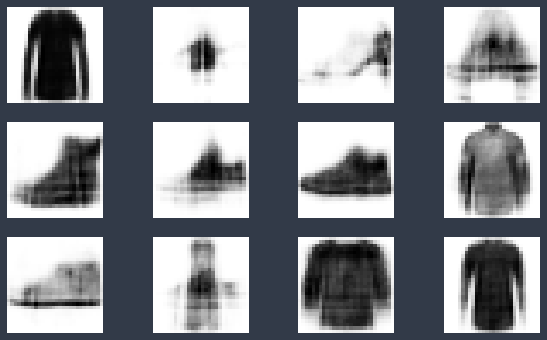

In [28]:
plot_multiple_images(images, 4)

With more fine-tuning and training time, the images generated can become better.

Another use for VAEs is for performing sematinc interpolation of nearby images. A simple example of interpolation is to overlay two images over each other (pixel interpolation).

With a VAE, instead of interpolating at pixel level, we can do it at the coding level and let the decoder output the result of the interpolation. 

In [32]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

In the code above, we organize the codings we just created in a 3x4 grid, resize the grid to 5x7 (by default TF `resize` uses bilinear interpolation, so every other row and column will contain interpolated encodings. We pass these to the decoder and plot

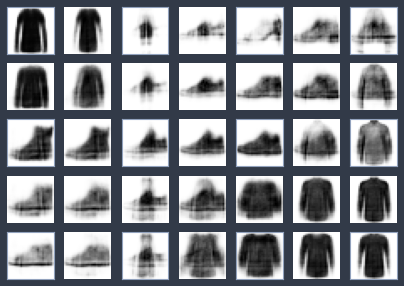

In [33]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

We'll now take a look at a more powerful way of generating more realistic and sharper images with Generative Adversarial Networks

## Generative Adversarial Networks

Introduced in 2014 by [Ian Goodfellow et al](https://arxiv.org/abs/1406.2661), GANs got researchers excited almost immediatelly but it took a few years to overcome some of the difficulties in training them. Their idea is simple: make two neural networks compete against each other in hope the competition will push them to excel. a GAN is composed of two networks

- *Generator*:
    Takes a random distribution as input (usually Gaussian) and outputs some data (e.g. an image). Think of the inputs as latents representations of the image to be generated. Note that the generator provides the same functionality as the decoder in a VAE, however it is trained differently
    
- *Discriminator*:
    Takes a fake image from the generator or a real image from the training set as input and must guesse whether the input image is fake or real
    
Bevause the GAN is composed of two networks with different objectives, it cannot be trained like a regular NN. Instead, each training iteration is divided in two phases:

- First phase: trains the discriminator. A batch of real images is sampled from the training set and is completed with an equal number of fake images produced by the generator. Labels are 0 for fake and 1 for real images. The discriminator is trained on this labelled batch for one step, using binary cross-entropy loss. Backpropagation only optimizes the weights of the discriminator during this phase.

- Phase two: train the generator. Generate a new batch of fake images and send it to be classified by the discriminator. This time we do not add real images in the bach and all images are set to 1 (real). We want the generator to produce images that the discriminator will believe to be real. The weights of the discriminator are frozen during this step and backpropagation will only affect the generator

Note that the generator never see any of the real images, yet it learns to produce convincing fake images! As the discriminator gets better, the more information about the real images is contained in the gradients flowing to the generator, so it can progress. Let's code it up!

As pointed out, the generator is just like a decoder, and the discriminator will be simply a binary classifier (taking images as input and final layer with 1 neuron).

In [6]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]), 
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Next we compile the models, the discriminator with binary cross-entropy while the generator will only be trained when we train the gan. The gan will also be a binary classifier so we can use binary cross-entropy as well, but we will also make the discriminator non-trainble before compiling the gan

In [7]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # Only taken into account in keras when compiling a model
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

We create the `Dataset` for the images and write a custom training loop

In [8]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # Phase 1 - Discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])  # Gaussian noise
            generated_images = generator(noise)  # Generate image
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)  # Create batch data
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)  # Label it
            discriminator.trainable = True  # To avoid keras warning
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Phase 2 - Generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

In [10]:
train_gan(gan, dataset, batch_size, codings_size)

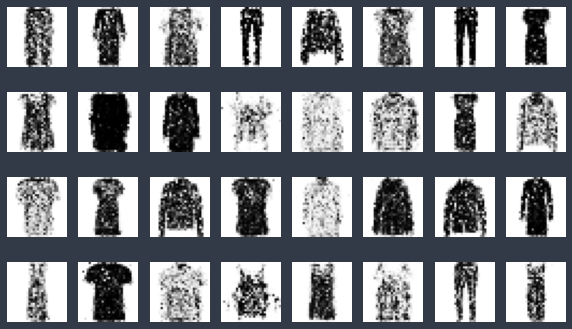

In [14]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Note: the [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) has nice plots at each iteration

You'll see that the GAN improves very slowly over time, sometimes even forgetting what it learned. This is due to the fact that training GANs is hard and we'll explore why in the next section

### Difficulties of training GANs

The book does a wonderful job of describing the two main issues: Nash equilibrium and mode collapse. Since this is a mostly theoretical part I won't re-do it here. Check page 597

Training GANs is an active field of research and a lot of progress has been done. Next, we'll explore some popular architectures

### Deep Convolutional GANs

The original paper experimented with convolutional layers for GANs, but only for small images. Researchers tried to build GANs with larger images with little success until in 2015 a paper was published on [Deep Convolutional GANs (DCGANs)](https://arxiv.org/abs/1511.06434). The main guidelines proposed for such architectures are

- Instead of pooling layers, use strided convolutions (in the discriminator) and transposed convolutions (in the generator)
- Use Batch normalization in both parts of the GAN, except in the generator's output layer and the discriminator's input layer
- Remove fully connected hidden layers for deeper architectures
- Use ReLU for all layers in the generator, except the output layer which should use tanh
- Use Leaky ReLU activation in all layers of the discriminator

The guidelines should work for many cases, but not always. Experimentation with hyperparameters is still necessary. Sometimes resetting the training seed and using the same model may work. Below is a small DCGAN fro Fashion MNIST

In [29]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

The generator will take codings of size 100 and project them into $7\times7\times28 = 6272$ dimensions reshaping it to get a 7x7x128 tensor (7x7 image, depth 128). These are batch normalized and then fed to a Conv2DTranspose with stride 2. This will upsample the image from 7x7 to 14x14 but reduce depth from 128 to 64. Again results are batch normalized and finally we upsample again from 14x14 to 28x28 and squeeze down to 1 dimension. Since the activation of the last layer is tanh, the outputs will be in the range [-1,1]. Thus we need to rescale the training set to the same range as well as reshaping the input to add the channel dimension (depth)

In [32]:
# MUltiply by two to shift the range to [0, 2] then subtract 1 to make it [-1, 1]
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

The discriminator looks like a regular CNN for binary classification but instead of using max pooling to downsample, we use strided convolutions (strides=2) as well as using leaky ReLU for the activation.

We followed all the guidelines above except the use of BatchNormalization in the discriminator, instead we used Dropout (author claims training was unstable)

In [33]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # Only taken into account in keras when compiling a model
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Rebuild the dataset now it has been scaled
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [34]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

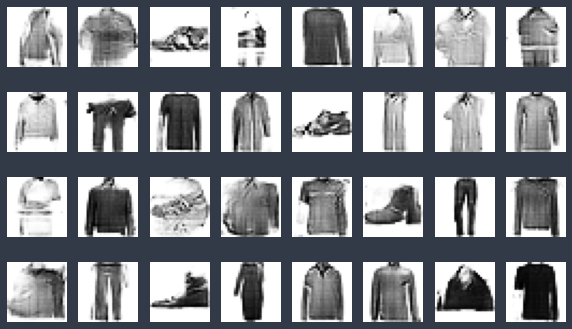

In [35]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Page 601 describes using GANs for face generation and interpolation. It also mentions [conditional GANs](https://arxiv.org/abs/1411.1784), where by adding an image class as an extra input to both generator and discriminator, they are able to learn it and we're able to control the calss of each image produced by the generator.

### Progressively Growing GANs, StyleGANs and more

The last section of the chapter talks about more training techniques for GANs such as gradually adding convolutional layers to both the generator and the discriminator, *minibatch standard deviation layer*, *equalized learning rate* and *pixelwise normalization layer*.

Finally, it introduces [StyleGANs](https://arxiv.org/abs/1812.04948) a powerful GAN that is able to generate very convincing images.